# Analysis with precomputed quantatities + missing data in Y

Here we analyze [an example of GTEx V7 cis-gene data-set](http://shiny.stephenslab.uchicago.edu/gaow/GTExV7/Multi_Tissues.ENSG00000145214.RDS).

In [1]:
%cd /home/gaow/tmp/13-May-2019

/home/gaow/Documents/TempDir/13-May-2019

In [2]:
raw_data = readRDS('Multi_Tissues.ENSG00000145214.RDS')

In [3]:
names(raw_data)

[1] "X"     "y"     "Z"     "y_res" "chrom" "pos"

In [4]:
dim(raw_data$X)

[1]  838 7962

In [5]:
dim(raw_data$y_res)

[1] 838  49

In [6]:
head(raw_data$y_res)

,Adipose_Subcutaneous,Adipose_Visceral_Omentum,Adrenal_Gland,Artery_Aorta,Artery_Coronary,Artery_Tibial,Brain_Amygdala,Brain_Anterior_cingulate_cortex_BA24,Brain_Caudate_basal_ganglia,Brain_Cerebellar_Hemisphere,⋯,Skin_Not_Sun_Exposed_Suprapubic,Skin_Sun_Exposed_Lower_leg,Small_Intestine_Terminal_Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole_Blood
GTEX-1117F,0.02125546,0.31798809,NA,NA,0.2393113,-1.04494665,NA,NA,NA,NA,⋯,0.15067370,NA,NA,NA,NA,NA,NA,0.01039438,0.722842,NA
GTEX-111CU,-0.39699365,-0.64860112,-0.005019028,NA,NA,NA,NA,NA,NA,NA,⋯,0.63489211,NA,0.001705089,-0.2423771,-0.23110084,-0.8254563,-0.72159107,NA,NA,NA
GTEX-111FC,0.12702099,NA,NA,NA,NA,-0.11075103,NA,NA,NA,NA,⋯,-0.27617936,0.003240822,NA,-0.1753999,NA,0.3182093,-0.44989562,NA,NA,NA
GTEX-111VG,-0.56557561,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,-0.18524402,-0.370778712,NA,NA,NA,-0.5285808,-0.47352474,NA,NA,NA
GTEX-111YS,-0.70396973,-0.19603980,0.245463191,0.04715705,NA,-0.07033531,NA,NA,NA,NA,⋯,-0.30672580,NA,0.492145996,NA,-0.08577711,-0.4095227,-0.47541942,NA,NA,-1.06802847
GTEX-1122O,0.04918042,-0.08174026,0.365081493,-0.07085276,-0.1343889,0.40367406,NA,NA,NA,NA,⋯,-0.09075013,0.394240061,0.404058046,-0.2285992,0.14804767,NA,-0.02374288,NA,NA,0.08137622


## Initialize data object

In [5]:
data = mmbr:::DenseData$new(raw_data$X, raw_data$y_res)

## Setting up MASH object

In [6]:
residual_covar = diag(apply(raw_data$y_res, 2, function(x) var(x, na.rm=T)))

In [7]:
prior_mats = mmbr:::create_cov_canonical(ncol(raw_data$y_res), singletons=F)

In [8]:
scaling = c(0.05,0.15,0.25,0.4) # FIXME: use auto-grid

In [8]:
mash_init = mmbr:::MashInitializer$new(prior_mats, scaling, alpha = 1)

In [9]:
mash_init$precompute_cov_matrices(data, residual_covar)

The line above currently takes 3m40s. **It is 2.5GB on disk in RDS format**. This is to compute for $R = 49, J = 7962, P = 21$. **$P$ is 21 for null weight plus at most 20 other components**. I saved it to disk,

In [10]:
saveRDS(mash_init, 'mash_init.rds')

```
-rw-r--r-- 1 gaow gaow  2.5G May 12 07:41 mash_init.rds
```

And test the memory it takes to keep it -- 7.42GB.

```bash
python ~/GIT/github/misc/monitor/monitor.py Rscript -e "mash_init = readRDS('mash_init.rds')"
```

```
time elapsed: 25.18s
peak first occurred: 15.40s
peak last occurred: 24.65s
max vms_memory: 7.42GB
max rss_memory: 7.23GB
memory check interval: 1s
return code: 0
```

 ## Fit one MASH regression model

In [14]:
mmbr_obj = mmbr:::MashMultipleRegression$new(ncol(raw_data$X), residual_covar, mash_init)

In [15]:
mmbr_obj$fit(data)

The step above now take 2 min. This is for one iteration. `MV-SuSiE` computation time will depend on how many iterations there are, as we will find out next. 

## Fit MV-SuSiE model

In [9]:
mash_init = readRDS('mash_init.rds')

In [10]:
res = mmbr::susie(raw_data$X,raw_data$y_res,
                  L=10,V=mash_init,
                  compute_objective=FALSE)

Code above takes 25 minutes to complete for L=5, >1hr for L=10.

In [11]:
saveRDS(res, "mmbr_res_10.rds")

## Visualize results

In [12]:
p = mmbr::mmbr_plot(res)

Suggested PDF canvas width: 5 height: 44.1 


In [23]:
pdf('mmbr_plot_ENSG00000145214.pdf', width = 20, height = 20)
print(p$plot)
dev.off()

png 
  2

In [22]:
pdf('susie_plot_ENSG00000145214.pdf', width=9, height=5)
susieR::susie_plot(res,y='PIP', main = 'Default SuSiE plot for cross-condition PIP', xlab = 'SNP positions', add_legend = T)
dev.off()

png 
  2

> susie_plot_ENSG00000145214.pdf (29.0 KiB):

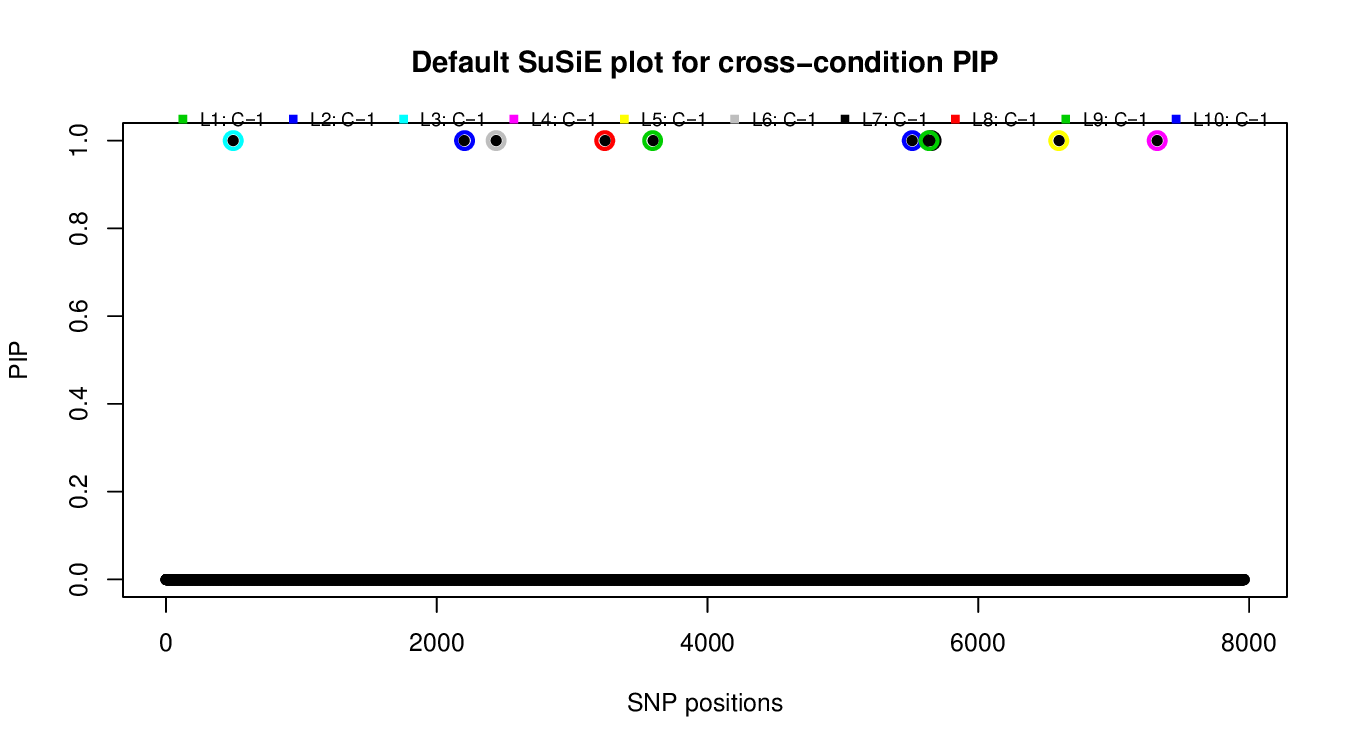

In [2]:
%preview susie_plot_ENSG00000145214.pdf -s png --dpi 150

> mmbr_plot_ENSG00000145214.pdf (10.8 KiB):

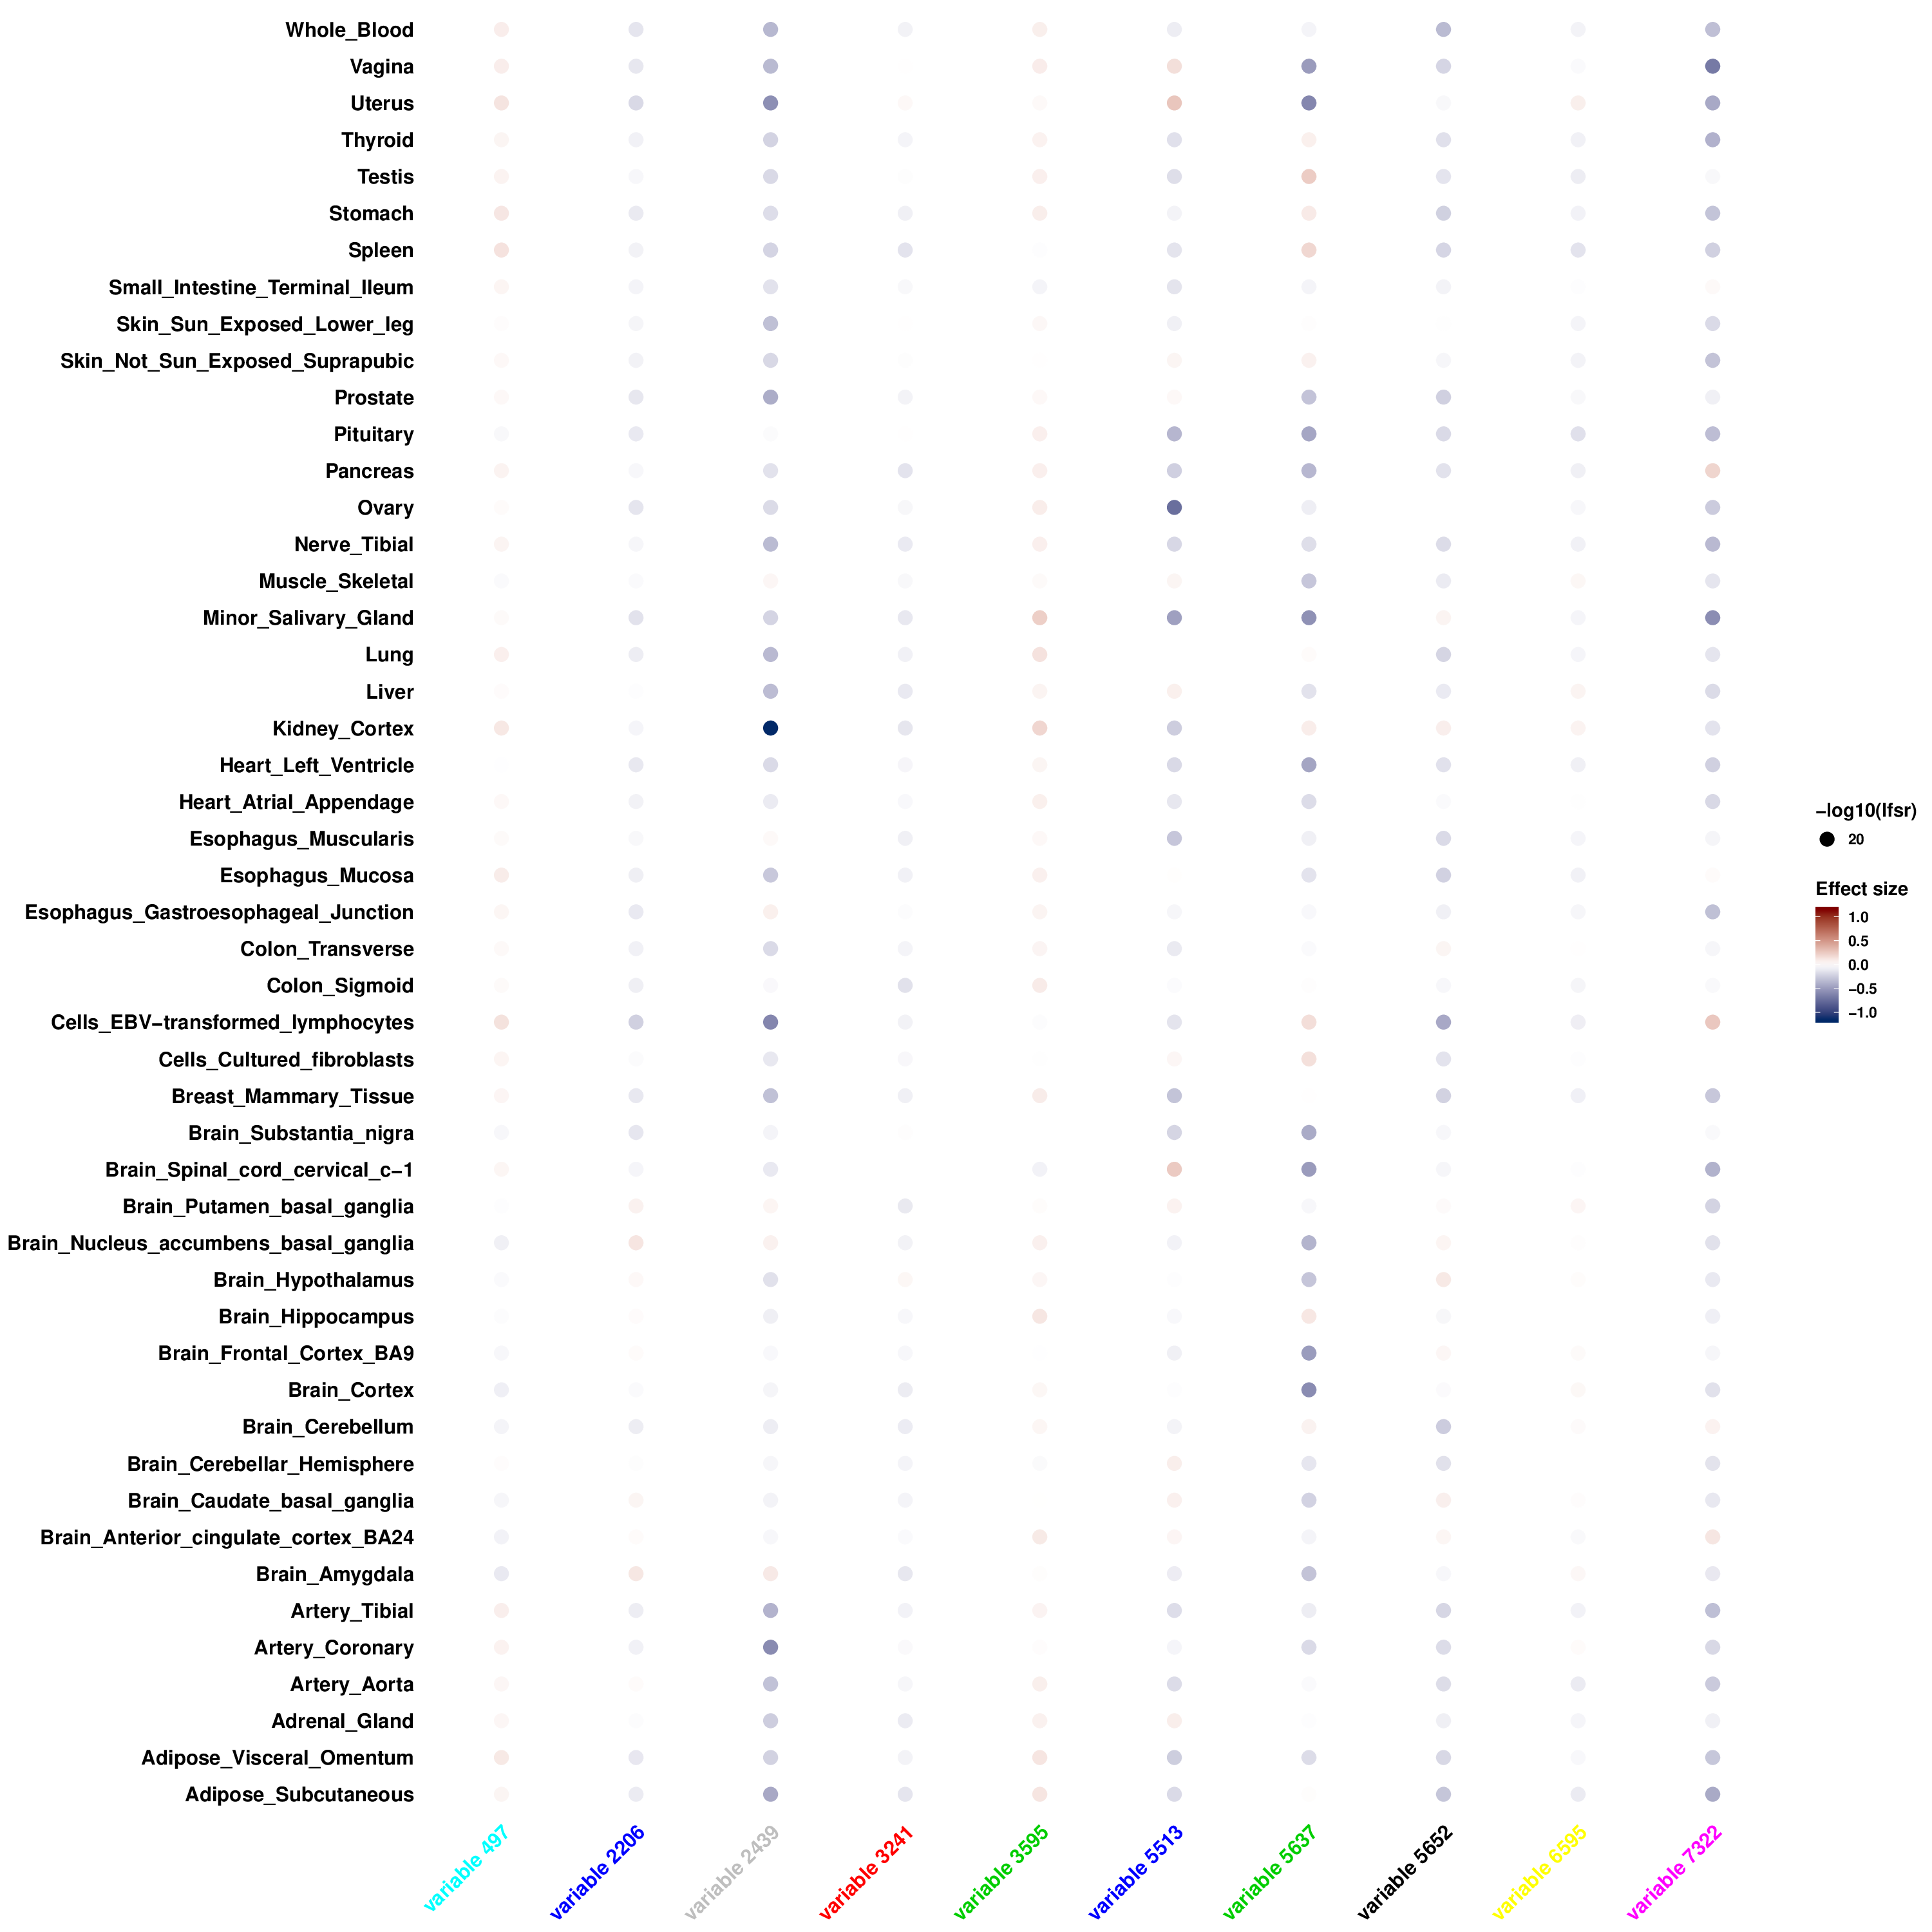

In [3]:
%preview mmbr_plot_ENSG00000145214.pdf -s png --dpi 150